In [1]:
import numpy as np
import pandas as pd
from keras.models import load_model
from keras.models import *
import cv2
from datetime import datetime
import time
from tqdm import tqdm
import os
from skimage import io

from matplotlib import pyplot as plt
%matplotlib inline

from unet.maskprocessor import *
from unet.normalization import *
from unet.loss import *

Using TensorFlow backend.
//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


The purpose of this notebook is: 
   To evaluate the model performance on unseen test set.  The test set is from DigitalGlobe which is lower resolution than the MapBox satellite imageries used in training set and validation set.

Pre-requisite:
   Directory containing the source of truth MapBox street tiles.  These could be obtained via the MapBox API.
   Directory containing the inferred mask tiles.  These tiles could be generated by roadSegmentationMaskGen.py.


In [2]:
dir_truth = '/Users/jkwok/Documents/Insight/tools/jTileDownloader 2/digitalglobe/mapbox_custom_street/'
dir_inferred = '/Users/jkwok/Documents/Insight/tools/jTileDownloader 2/digitalglobe/jackkwok.digitalglobe_harvey_3020132_tif_mask/'

model_file = '/Users/jkwok/Documents/Insight/models/Unet_Dilated-20170917-223544.hdf5'
model = load_model(model_file, custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})

//anaconda/lib/python2.7/site-packages/keras/models.py:287: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [3]:
def image_file_list(dir_path):
	""" limitation: the images files must have an image extension: webp, jpg, png, or jpeg """
	result = []
	for root, dirs, files in os.walk(dir_path):
		for file in files:
			if file.endswith('.webp') or file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg'):
				result.append(os.path.join(root, file))
	return result

In [10]:
inferred_filelist = image_file_list(dir_inferred)

truth_filelist = []

for img_file in inferred_filelist:
    truth_file = img_file.replace(dir_inferred, dir_truth)
    truth_file = truth_file.replace('.jpg', '.png')
    truth_filelist.append(truth_file)

img_df = pd.DataFrame(
    {'infer': inferred_filelist,
     'truth': truth_filelist,
    })

img_df.head()

,infer,truth
0,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...
1,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...
2,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...
3,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...
4,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...


/Users/jkwok/Documents/Insight/tools/jTileDownloader 2/digitalglobe/jackkwok.digitalglobe_harvey_3020132_tif_mask/16/15456/27063.jpg
/Users/jkwok/Documents/Insight/tools/jTileDownloader 2/digitalglobe/mapbox_custom_street/16/15456/27063.png
(512, 512, 3)
(512, 512, 3)
('binary mask', array([False,  True], dtype=bool))
[0]
[  0 255]
0.0


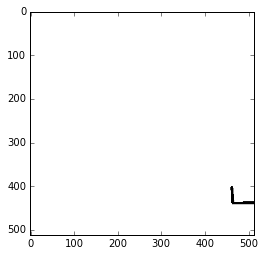

In [17]:
infer_jpg_filename = img_df.loc[0, 'infer']
truth_jpg_filename = img_df.loc[0, 'truth']
print(infer_jpg_filename)
print(truth_jpg_filename)

infer_jpg_img = cv2.imread(infer_jpg_filename)
truth_jpg_img = cv2.imread(truth_jpg_filename)

print(infer_jpg_img.shape)
print(truth_jpg_img.shape)

infer_image = cv2.cvtColor(infer_jpg_img, cv2.COLOR_BGR2GRAY)

mask = get_street_mask(truth_jpg_img)
print('binary mask', np.unique(mask))

plt.imshow(mask, cmap=plt.cm.binary)
new_style = {'grid': False}

mask.dtype='uint8'
mask[mask == 1] = 255

print(np.unique(infer_image))
print(np.unique(mask))

dice = np.sum(infer_image[mask==255])*2.0 / (np.sum(infer_image) + np.sum(mask))

print(dice)

In [20]:
# compute dice coef score between source of truth and prediction

for i in tqdm(range(len(inferred_filelist)), miniters=10):
    infer_jpg_filename = img_df.loc[i, 'infer']
    truth_jpg_filename = img_df.loc[i, 'truth']

    infer_jpg_img = cv2.imread(infer_jpg_filename)
    truth_jpg_img = cv2.imread(truth_jpg_filename)
    
    infer_image = cv2.cvtColor(infer_jpg_img, cv2.COLOR_BGR2GRAY)
    
    mask = get_street_mask(truth_jpg_img)
    mask.dtype='uint8'
    mask[mask == 1] = 255

    #print(np.unique(infer_image))
    #print(np.unique(mask))

    dice = np.sum(infer_image[mask==255])*2.0 / (np.sum(infer_image) + np.sum(mask))
    
    img_df.set_value(i, 'dice_coef', dice)


100%|██████████| 288/288 [00:02<00:00, 132.87it/s]

In [22]:
img_df.head()

,infer,truth,dice_coef
0,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.000000
1,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.334974
2,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.000000
3,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.281868
4,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.286813


In [29]:
dice_file_path = 'dice/' + os.path.splitext(model_filename)[0] + '.csv'
img_df.to_csv(dice_file_path, index=False)

In [27]:
print(img_df.loc[188, 'infer'])
print(img_df.loc[188, 'truth'])
print(img_df.loc[188, 'dice_coef'])

/Users/jkwok/Documents/Insight/tools/jTileDownloader 2/digitalglobe/jackkwok.digitalglobe_harvey_3020132_tif_mask/16/15466/27071.jpg
/Users/jkwok/Documents/Insight/tools/jTileDownloader 2/digitalglobe/mapbox_custom_street/16/15466/27071.png
0.880150761601


In [29]:
x = img_df[img_df['dice_coef']!=0]
avg_dice = x.mean()
print 'average dice score: ', avg_dice

average dice score:  dice_coef    0.270229
dtype: float64


In [24]:
sorted_df = img_df.sort_values('dice_coef', ascending=False)
sorted_df.head(100)

,infer,truth,dice_coef
188,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.880151
263,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.845667
281,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.825526
205,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.724384
73,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.638420
38,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.601978
264,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.576114
242,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.554498
224,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.552646
211,/Users/jkwok/Documents/Insight/tools/jTileDown...,/Users/jkwok/Documents/Insight/tools/jTileDown...,0.547499


In [37]:
# What if we handpick these as validation data?  Drawback: 'difficult' cars are excluded from validation score.
sorted_df = train_df.sort_values('dice_coef', ascending=False)
sorted_df.head(480)

,img,dice_coef
3174,9ab2a45de8c7_07.jpg,0.998588
3173,9ab2a45de8c7_06.jpg,0.998479
1198,36a3f7f77e85_15.jpg,0.998464
2038,61060ada97c9_07.jpg,0.998414
218,0de66245f268_11.jpg,0.998404
658,2267f4aa0d2c_03.jpg,0.998397
849,2af7c265531e_02.jpg,0.998358
4296,d9b2ded58b72_09.jpg,0.998355
4254,d8216041ffa9_15.jpg,0.998350
3007,8d1a6723c458_16.jpg,0.998321


In [38]:
len(sorted_df.index)

5088

In [40]:
sorted_dice_file_path = data_dir + 'dice/sorted_' + os.path.splitext(model_filename)[0] + '.csv'
sorted_df.to_csv(sorted_dice_file_path, index=False)

In [42]:
# Handpick validation set of size 480.  Rest will be used for training.
validation_set_df = sorted_df.head(480)
training_set_df = sorted_df.tail(5088-480)
training_set_df = training_set_df.sample(frac=1).reset_index(drop=True)
validation_set_df.to_csv(data_dir + 'validation_set.csv', index=False)
training_set_df.to_csv(data_dir + 'train_set.csv', index=False)